# Constructing a Grid from Points

In many cases, data can be represented as an unstructured series of points, including data from climate models when not paired with any connectivity information or radar observations. UXarray is written around the UGRID conventions, which requires a minimal
set of coordinate and connectivity variables to represent a two-dimensional grid. This notebook demonstrates how grid connectivity can be constructured using point data.


In [1]:
import uxarray as ux
import xarray as xr
import cartopy.crs as ccrs
import geoviews as gv
import geoviews.feature as gf
import warnings

import holoviews as hv

hv.extension("matplotlib")

warnings.filterwarnings("ignore")

## Types of Point Data

Different types of point data can be encountered depending on the coverage and structure of the data. The following table categorizes these types, providing examples of common use cases.

| **Domain**        | **Description**                              |
|:---------------------------|:--------------------------------------------------------------------------|
| **Global**              | Data that covers the entire globe (e.g., atmospheric or climate simulations)|
| **Global with Holes**   | Data that spans most of the globe but has gaps or regions without observations (e.g., land-only or ocean-only data). |
| **Regional**            | Data that is limited to a specific area (e.g. local weather forecasts or satellite observations) |
| **Regional with Holes** | Regional data with missing sections or observations within the area of interest, often due to obstacles or coverage limitations. |


For this notebook, we will be using the coordinates from three testing grids to represent our point data:
* `outCSne30.ug`: Global Cube Sphere Grid
* `oQU480.23010.nc`: Global Ocean Grid
* Subset of `outCSne30.ug`: 9 points centered about (0, 0) 

:Layout
   .Overlay.I   :Overlay
      .Points.I :Points   [lon,lat]
      .Grid.I   :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Points.I :Points   [lon,lat]
      .Grid.I   :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Points.I :Points   [lon,lat]
      .Grid.I   :Feature   [Longitude,Latitude]
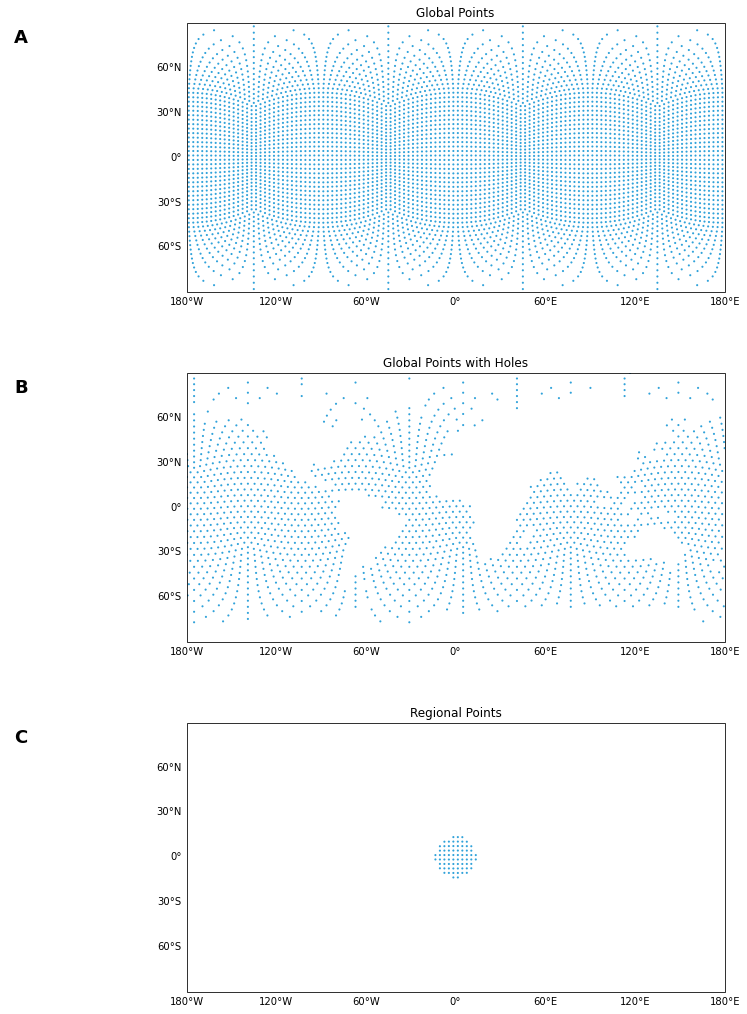

In [2]:
uxgrid_global = ux.open_grid("../../test/meshfiles/ugrid/outCSne30/outCSne30.ug")
uxgrid_global_ocean = ux.open_grid("../../test/meshfiles/mpas/QU/oQU480.231010.nc")
uxgrid_global_ocean.normalize_cartesian_coordinates()
uxgrid_regional = uxgrid_global.subset.nearest_neighbor((0.0, 0.0), k=50)

(
    uxgrid_global.plot.face_centers(
        global_extent=True,
        features=["grid"],
        title="Global Points",
        height=500,
        width=1000,
        s=20,
    )
    + uxgrid_global_ocean.plot.face_centers(
        global_extent=True,
        features=["grid"],
        title="Global Points with Holes",
        height=500,
        width=1000,
        s=20,
    )
    + uxgrid_regional.plot.face_centers(
        global_extent=True,
        features=["grid"],
        title="Regional Points",
        height=500,
        width=1000,
        s=20,
    )
).cols(1).opts(fig_size=300)

## Preparing Point Data

UXarray's ``Grid.from_points()`` method supports both Spherical (lon and lat) and Cartesian (x, y, z) coordinates. It is important to note that the coordinate arrays must be unique in order to run the following methods.

Below we extract the Cartesian (x, y, z) coordinates which we will use for constructing our grid.


In [ ]:
x_global, y_global, z_global = (
    uxgrid_global.face_x.values,
    uxgrid_global.face_y.values,
    uxgrid_global.face_z.values,
)
points_global = (x_global, y_global, z_global)

In [ ]:
x_global_ocean, y_global_ocean, z_global_ocean = (
    uxgrid_global_ocean.face_x.values,
    uxgrid_global_ocean.face_y.values,
    uxgrid_global_ocean.face_z.values,
)
points_global_ocean = (x_global_ocean, y_global_ocean, z_global_ocean)
boundary_points_global_ocean = uxgrid_global_ocean.boundary_face_indices.values

In [3]:
x_regional, y_regional, z_regional = (
    uxgrid_regional.face_x.values,
    uxgrid_regional.face_y.values,
    uxgrid_regional.face_z.values,
)
points_regional = (x_regional, y_regional, z_regional)

## Global Data

The following algorithms will returns grids with a full coverage of the surface of a sphere, which makes them suitable for constructing connectivity from global point data.

###  Spherical Delaunay

The `spherical_delaunay` method in the `Grid.from_points()` function is designed to perform Delaunay triangulation on points distributed over a spherical surface. 

#### How It Works

1. **Input Points on the Sphere**:
   - The method accepts input points defined in spherical coordinates (e.g., latitude and longitude) or Cartesian coordinates (x, y, z) that lie on the surface of the sphere. They are internally converted to normalized Cartesian coordinates.

2. **Computing the Convex Hull**:
   - The algorithm computes the **Convex Hull** of the set of Cartesian points. The convex hull is the smallest convex shape that encloses all the points. In three dimensions, the convex hull forms a polyhedron where each face is a triangle.

3. **Extracting Triangles**:
   - Once the convex hull is determined, the triangular faces of the hull are extracted. These triangles represent the Delaunay triangulation on the sphere's surface, ensuring that no point is inside the circumcircle of any triangle, which is a key property of Delaunay triangulations.


In [38]:
%%time
grid_dt = ux.Grid.from_points(points_global, method="spherical_delaunay")

CPU times: user 33.8 ms, sys: 1.8 ms, total: 35.6 ms
Wall time: 34.2 ms


:Path   [Longitude,Latitude]
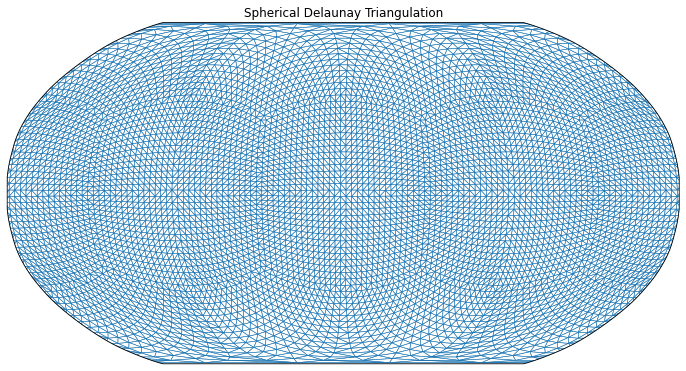

In [39]:
grid_dt.plot(
    projection=ccrs.Robinson(),
    linewidth=0.5,
    periodic_elements="split",
    title="Spherical Delaunay Triangulation",
    height=500,
    width=1000,
)

The resulting grid will always be strictly triangular and cover the entire sphere.

In [ ]:
grid_dt.triangular

In [ ]:
grid_dt.plot.face_degree_distribution()

In [ ]:
grid_dt.plot.face_area_distribution(bins=10)

In [ ]:
grid_dt.global_sphere_coverage

Zooming in, we can observe the Delaunay Triangles in detail. The original point coordinates are now the corners of our faces. This means that any data that was originally mapped to the points will reside on the corner nodes.

In [ ]:
(grid_dt.plot() * uxgrid_global.plot.face_centers(color="red", s=1000)).opts(
    xlim=(-10, 10),
    ylim=(-5, 5),
    title="Spherical Delaunay Triangles (Zoomed)",
)

### Spherical Voronoi


The `spherical_voronoi` method in the `Grid.from_points()` function is designed to generate a Voronoi tessellation on points distributed over a spherical surface. This method leverages SciPy's Spherical Voronoi functionality internally.

### How It Works

1. **Input Points on the Sphere**:
   - The method accepts input points defined in spherical coordinates (e.g., latitude and longitude) or Cartesian coordinates (x, y, z) that lie on the surface of the sphere. They are internally converted to normalized Cartesian coordinates.

2. **Computing the Spherical Voronoi Diagram**:
   - Using SciPy's `SphericalVoronoi` class, the algorithm computes the Voronoi tessellation on the sphere. This involves determining the regions on the sphere where each region contains all points closer to one generating point than to any other.

3. **Constructing Voronoi Regions**:
   - The Spherical Voronoi algorithm identifies the vertices and edges that define each Voronoi region. Each region corresponds to one input point and consists of a polygon on the sphere's surface.


In [ ]:
%%time
grid_sv = ux.Grid.from_points(points_global, method="spherical_voronoi")

In [ ]:
grid_sv.plot(
    projection=ccrs.Robinson(),
    linewidth=0.5,
    periodic_elements="split",
    height=500,
    width=1000,
    title="Spherical Voronoi Tesselation",
)

The resulting grid consists of mostly 6-sided faces, with small numbers of faces with 4, 5, 7, and 8 sides.

In [ ]:
grid_sv.plot.face_degree_distribution()

In [ ]:
grid_sv.plot.face_area_distribution(bins=15)

In [ ]:
grid_sv.global_sphere_coverage

Zooming in, we can observe the Voronoi Regions in detail. The original point coordinates are now the centers of each the faces in the grid. This means that any data that was originally mapped to the points now resides on the faces.

In [ ]:
(grid_sv.plot() * uxgrid_global.plot.face_centers(color="red")).opts(
    xlim=(-10, 10),
    ylim=(-5, 5),
    title="Spherical Voronoi Cells (Zoomed)",
)

In [ ]:
(grid_sv.plot() * uxgrid_global.plot.face_centers(color="red")).opts(
    xlim=(14.5, 18.5),
    ylim=(5.5, 9.0),
    title="Single Spherical Voronoi Cell (Zoomed)",
)

### Limitations of Spherical Methods

The spherical methods discussed above are not appropriate for regional data, as the exterior boundaries of the region will wrap around and connect together, forming extremely large faces.

In [ ]:
%%time
grid_dt_regional = ux.Grid.from_points(points_regional, method="spherical_delaunay")

In [ ]:
grid_dt_regional.plot.face_area_distribution(
    bins=15, title="Delaunay: Face Area Distributon (Regional)"
)

In [ ]:
grid_sv_regional = ux.Grid.from_points(points_regional, method="spherical_voronoi")

In [ ]:
grid_sv_regional.plot.face_area_distribution(
    bins=15, title="Voronoi: Face Area Distributon (Regional)"
)

## Global Data with Holes


For global point data with holes, the spherical methods can be used, but there are certain considerations that need to be made, since by default, each spherical method returns a grid with full sphere coverage.

### Spherical Delaunay

In [ ]:
%%time
grid_dt = ux.Grid.from_points(points_global_ocean, method="spherical_delaunay")

In [ ]:
grid_dt.global_sphere_coverage

In [ ]:
grid_dt.plot(
    projection=ccrs.Robinson(),
    linewidth=0.5,
    periodic_elements="exclude",
    title="Spherical Delaunay Triangulation",
    height=500,
    width=1000,
)

In [ ]:
(
    grid_dt.plot(
        features=["coastline"],
    )
    * uxgrid_global_ocean.plot.face_centers(color="red")
).opts(
    xlim=(-20, 20),
    ylim=(-10, 10),
    title="Spherical Delaunay Triangles (Zoomed)",
)

This behavior is not always desired, especially if you do not want elements over previously empty regions. The ``Grid.from_points()`` method accepts an optional argument ``boundary_points``, which is an array of indices corresponding to which points lie on a defined boundary.

In [ ]:
%%time
grid_dt_no_boundary = ux.Grid.from_points(
    points_global_ocean,
    boundary_points=boundary_points_global_ocean,
    method="spherical_delaunay",
)

When appropriate boundary points are provided, the resulting grid has a partial sphere coverage. 

In [ ]:
grid_dt_no_boundary.global_sphere_coverage

In [ ]:
grid_dt_no_boundary.plot(
    projection=ccrs.Robinson(),
    linewidth=0.5,
    periodic_elements="exclude",
    height=500,
    width=1000,
    title="Spherical Delaunay Triangulation without Boundary Points",
)

In [ ]:
(
    grid_dt_no_boundary.plot(
        features=["coastline"],
    )
    * uxgrid_global_ocean.plot.face_centers(color="red")
).opts(
    xlim=(-20, 20),
    ylim=(-10, 10),
    title="Spherical Delaunay Triangles without Boundary Points (Zoomed)",
)

### Spherical Voronoi

The Spherical Voronoi method can be used for global poitns with holes, however it does not support a ``boundary_points`` parameter, meaning that the resulting Grid will always have a global sphere coverage.


In [ ]:
%%time
grid_sv = ux.Grid.from_points(points_global_ocean, method="spherical_voronoi")

In [ ]:
grid_sv.global_sphere_coverage

In [ ]:
grid_sv.plot(
    projection=ccrs.Robinson(),
    linewidth=0.5,
    periodic_elements="exclude",
    height=500,
    width=1000,
    title="Spherical Voronoi Regions",
)

In [ ]:
(
    grid_sv.plot(
        features=["coastline"],
    )
    * uxgrid_global_ocean.plot.face_centers(color="red")
).opts(
    xlim=(-20, 20),
    ylim=(-10, 10),
    title="Spherical Voronoi Regions (Zoomed)",
)

## Regional Data

```{warning}
Constructing a grid from regional point data is not yet supported.
```

In [4]:
grid_r = ux.Grid.from_points(points_regional, method="regional_delaunay")

:Path   [Longitude,Latitude]
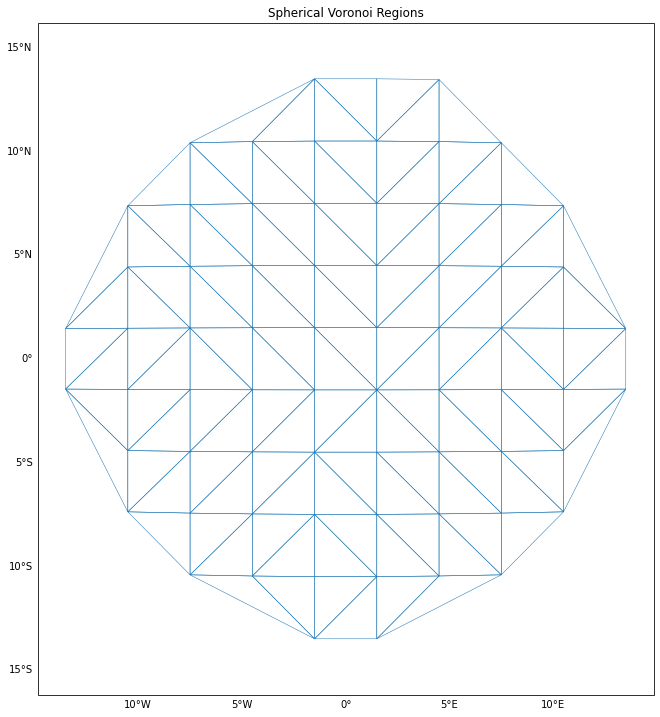

In [6]:
grid_r.plot(
    linewidth=0.5,
    periodic_elements="exclude",
    height=500,
    width=1000,
    title="Regional Delaunay Regions",
)